In [1]:
import glob
import csv
import pandas as pd
import flexynesis
from collections import defaultdict
from itertools import islice
from tabulate import tabulate

[rank: 0] Seed set to 42


- Input files were generated using a Slurm array job and `flex_conf.tsv`, so very easy to iterate over many combinations (98 in total)
- Files are on [github](https://github.com/kjthoward/compgen2025/tree/main/module_3)
    - KH_day3_test_models_gpu_array.job was used to generate the data
        - Used flex_conf.tsv for list of variables to test
    - flexynesis_runs_gpu contains the outputs
- Command used to run `flexynesis` was:
```
flexynesis --data_path ./ccle_vs_gdsc/ --target_variables Erlotinib \
    --hpo_iter 100 --features_top_percentile 10 --outdir ./flexynesis_runs \
    --model_class ${class} \
    --data_types ${data_type} \
    --fusion_type ${fusion_type} \
    --prefix ${prefix} 
```
- Where `class`, `data_type`, `fusion_type` and `prefix` (to name the output files) were taken from the config file
- Was based on the other parameters. e.g:
    - class = `DirectPred`
    - data_type = `cnv,rna`
    - fusion_type = `early`
    - prefix = `DP_cnv_rna_early`
    

In [2]:
#First get list of files, check we have correct number
stats_files = glob.glob("flexynesis_runs_gpu/*.stats.csv")
if len(stats_files)==0:
    raise Exception("WARNING - No stats files found!")
else:
    print(len(stats_files))

70


In [3]:
#Get pearson corr values for each file and store in default dict
pearson_values=defaultdict(float)
for file in stats_files:
    with open(file,"rt") as f_in:
        data_in=csv.DictReader(f_in)
        for row in data_in:
            if row["metric"]=="pearson_corr":
                pearson_values[file.removesuffix(".stats.csv")]=float(row["value"])
    

In [4]:
# Sort by value to get highest first
# NOTE - use abs since Pearson correlation goes from -1 to +1
print(tabulate([[k.split("/")[1], v] for k, v in sorted(pearson_values.items(), key=lambda item: abs(item[1]), reverse=True)],headers=["File", "Rank"]))


File                                      Rank
----------------------------------  ----------
DP_cnv_rna_intermediate             0.442977
DP_rna_early                        0.432765
DP_mutation_rna_intermediate        0.431637
DP_mutation_rna_early               0.407984
RF_rna_intermediate                 0.395603
SVAE_cnv_rna_intermediate           0.393623
RF_mutation_rna_early               0.393196
SVAE_mutation_rna_early             0.391337
RF_cnv_rna_intermediate             0.390664
XGB_mutation_rna_early              0.386213
SVAE_cnv_mutation_rna_intermediate  0.383251
RF_mutation_rna_intermediate        0.382885
XGB_rna_early                       0.381653
RF_cnv_rna_early                    0.381051
RF_rna_early                        0.380996
XGB_mutation_rna_intermediate       0.380361
RF_cnv_mutation_rna_intermediate    0.37719
SVAE_mutation_rna_intermediate      0.374065
RF_cnv_mutation_rna_early           0.373031
DP_rna_intermediate                 0.36828
SVAE_rna

In [5]:
# Above gives complete ranking, but we just want to take the best. Could just copy from above, this does it without aditional input though
best_score=float('-inf')
best_file=None
for file, score in pearson_values.items():
    if abs(score)>best_score:
        best_score=abs(score)
        best_file=file
#Note - Taking Pearson value from the dictionary here, rather than "best_score". Since best_score is abs(score) and we want to see it's sign here
print(f"The best model was {best_file.split('/')[1]} with a pearson correlation of {round(pearson_values[best_file],4)}")

The best model was DP_cnv_rna_intermediate with a pearson correlation of 0.443


In [6]:
best_test_E = pd.read_csv(f"{best_file}.embeddings_test.csv",index_col=0)
best_test_E.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E246,E247,E248,E249,E250,E251,E252,E253,E254,E255
HT-29,-3.171900,18.702538,16.695679,-18.600662,-0.033051,-22.472208,-15.506233,9.368230,-20.241167,-21.360952,...,0.749394,2.517033,-3.744225,5.271393,4.407147,-1.782970,5.572323,-1.463737,-0.760525,-2.014184
TE-10,-5.035516,9.025412,2.040252,-9.834312,4.803314,-3.681761,-6.823434,8.031839,-9.192232,-6.662601,...,2.546551,2.373228,0.448883,3.113077,1.183433,-2.826138,3.800957,-5.776217,-5.536785,-5.137627
HN,-0.640362,11.684107,11.424771,-10.792943,-1.444747,-14.353040,-9.421462,4.348380,-10.828207,-13.834265,...,2.986355,1.630191,1.261580,2.670994,1.228784,-2.075662,2.751089,-4.295558,-5.707898,-4.030464
SW872,-0.449053,22.439035,25.262285,-20.846043,-3.861798,-28.585697,-16.333190,8.779837,-23.136106,-26.060806,...,0.928145,1.816424,2.143061,-1.430612,-1.716702,2.108449,-1.690034,-0.071273,-2.812033,1.615029
HuP-T3,11.866579,-10.889995,-6.932766,5.245561,-2.116546,7.728584,-4.267910,2.028524,13.129321,8.234860,...,2.864888,2.600814,-0.976345,4.039387,1.507885,-2.981340,4.876896,-3.670703,-5.302393,-5.122041


In [7]:
best_train_E = pd.read_csv(f"{best_file}.embeddings_train.csv",index_col=0)
best_train_E.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E246,E247,E248,E249,E250,E251,E252,E253,E254,E255
HT-29,-1.091322,15.224613,16.648972,-14.422094,-2.383394,-19.867304,-11.618456,6.140396,-16.393131,-18.172298,...,3.574783,2.739942,-3.191035,6.489669,3.882734,-4.624789,6.183369,-2.486180,-3.034537,-5.376036
EFE-184,-1.686388,2.033938,-1.647987,-5.170491,3.086606,-3.286962,-7.165794,5.021836,-3.133883,-3.637360,...,3.691613,1.272559,0.346029,2.355675,-0.455132,-2.932578,1.718532,-1.850995,-4.419910,-4.896546
SNU-738,18.399225,-16.493600,-5.161220,10.380494,-6.891843,8.851066,-2.662938,-1.304468,18.560820,11.844522,...,1.846785,1.790869,2.693661,-1.987560,-3.833142,0.503751,-2.615804,0.469919,-3.031726,-0.076743
UM-RC-6,4.603933,24.928680,48.100100,-20.128560,-19.839441,-42.647026,-13.696178,0.309648,-26.777197,-38.815910,...,4.569434,2.874985,0.448330,4.399691,0.013148,-3.495423,4.090999,-4.122365,-7.907414,-7.275481
JHH-2,-5.058876,10.372157,3.365797,-16.254572,6.690586,-13.717236,-16.479500,10.107477,-11.913871,-14.387070,...,4.581519,0.732278,6.648257,-5.849446,-8.857156,0.902111,-7.666628,1.938895,-4.404955,1.117236


In [8]:
clin_data=pd.read_csv("./ccle_vs_gdsc/train/clin.csv",index_col=0)


In [9]:
#Get sample types for PCA
sample_tissues=defaultdict(str)
for i,row in clin_data.iterrows():
    if row["Erlotinib"]:
        sample_tissues[row.name]=row["tissueid"]
train_labels = [sample_tissues[x] if x in sample_tissues.keys() else "NOT SPECIFIED" for x in best_train_E.index]

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


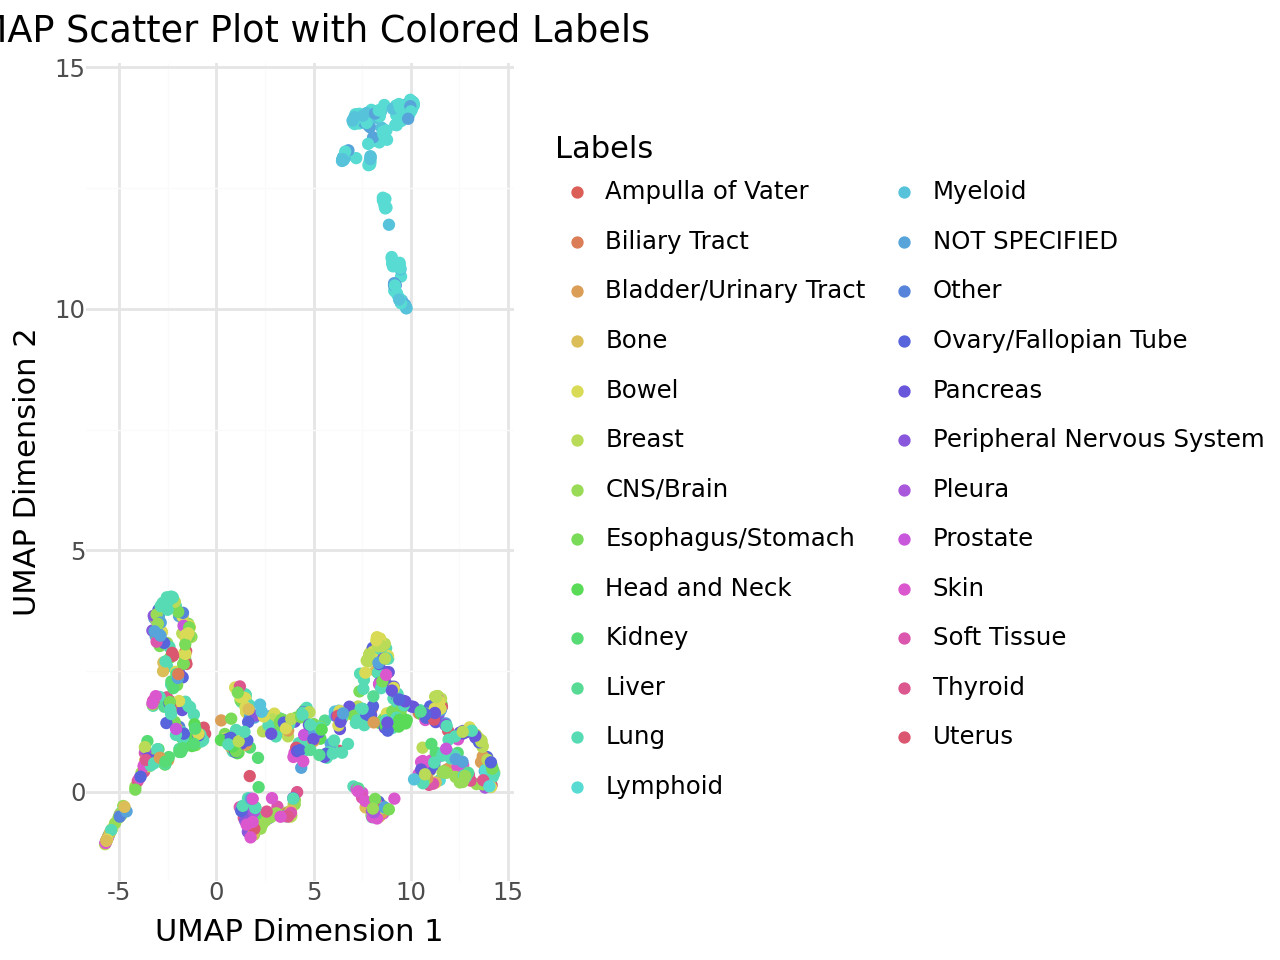

In [10]:
flexynesis.plot_dim_reduced(best_train_E, labels=train_labels, color_type = 'categorical', method='umap')

In [11]:
#Get sample types for PCA
sample_tissues=defaultdict(str)
for i,row in clin_data.iterrows():
    if row["Erlotinib"]:
        sample_tissues[row.name]=row["tissueid"]
test_labels = [sample_tissues[x] if x in sample_tissues.keys() else "NOT SPECIFIED" for x in best_test_E.index]

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


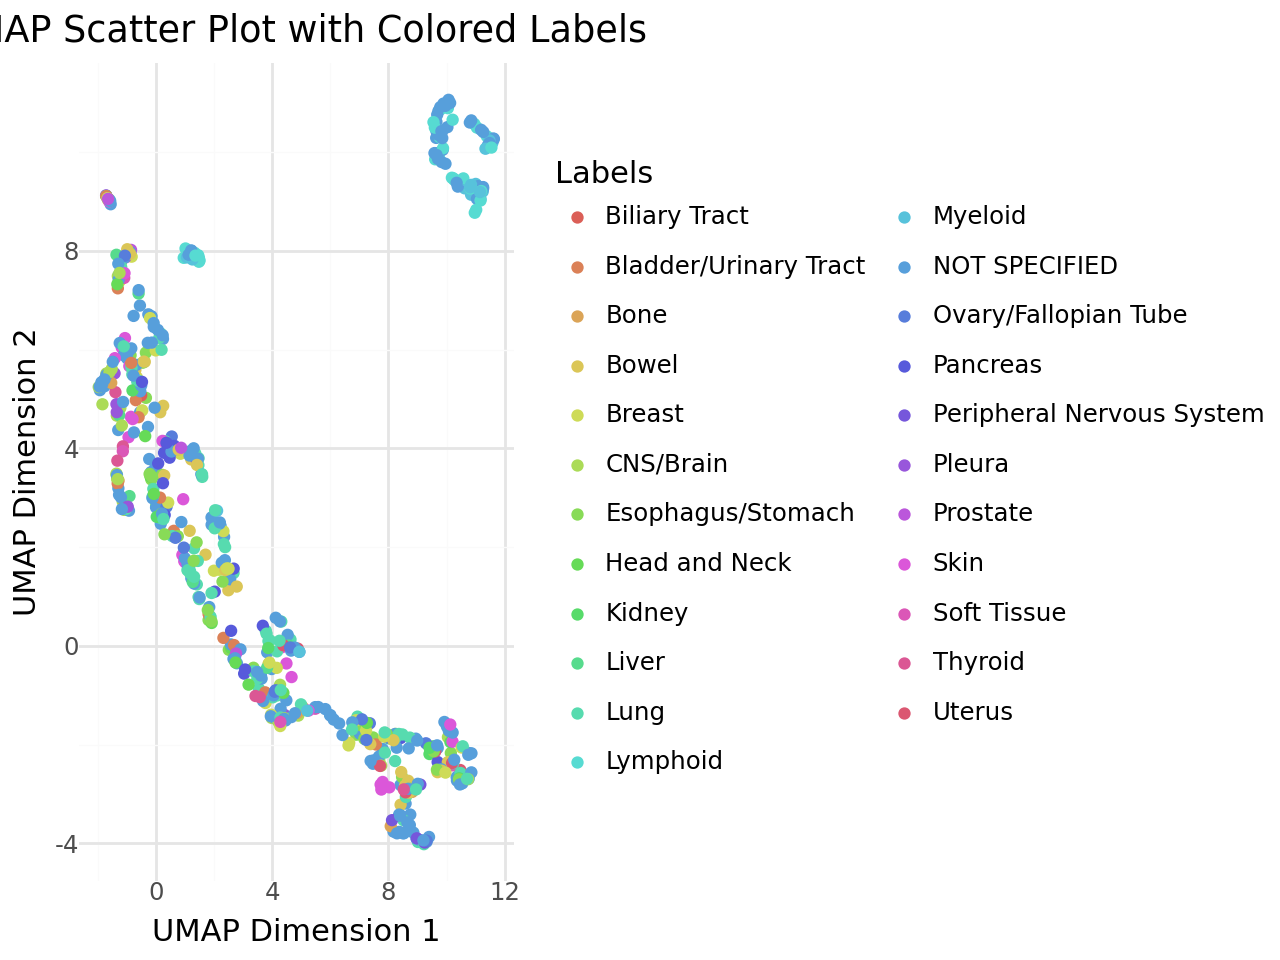

In [12]:
flexynesis.plot_dim_reduced(best_test_E, labels=test_labels, color_type = 'categorical', method='umap')

In [13]:
feature_scores_rna={}
feature_scores_cnv={}
feature_scores_mut={}
with open(f"{best_file}.feature_importance.IntegratedGradients.csv","rt") as f:
    data_in=csv.DictReader(f)
    for row in data_in:
        if row["layer"]=="cnv":
            feature_scores_cnv[row["name"]]=float(row["importance"])
        elif row["layer"]=="rna":
            feature_scores_rna[row["name"]]=float(row["importance"])
        elif row["layer"]=="mutation":
            feature_scores_mut[row["name"]]=float(row["importance"])

In [14]:
print(tabulate([[k, v] for k, v in sorted(feature_scores_rna.items(), key=lambda item: (item[1]), reverse=True)][:20],headers=["Gene", "Importance"]))

Gene       Importance
-------  ------------
EVPL       0.00245805
SACS       0.00241299
VILL       0.00230411
PCYOX1     0.00226497
ICA1       0.00214187
HKDC1      0.00206526
SLC44A4    0.00201588
NUAK2      0.00196789
LRRC8E     0.00194765
CELF2      0.00191327
LPAR1      0.00185839
XDH        0.00184949
EGFR       0.0018306
DPYSL3     0.00177932
DKK1       0.00176761
LYPD3      0.00175193
FAM216A    0.00174877
CLDN4      0.00174467
POU2AF1    0.00174066
EAF2       0.0017343


### Top 10 features from RNA data:
- EVPL
- SACS
- VILL
- PCYOX1
- ICA1
- HKDC1
- SLC44A4
- NUAK2
- LRRC8E
- CELF2

None of these seem to have any known association with Erlotinib, however NUAK2 and HKDC1 has been implicated in progression of some cances and are kinases, so may have some possible interactions with Erlotinib

In [15]:
print(tabulate([[k, v] for k, v in sorted(feature_scores_cnv.items(), key=lambda item: (item[1]), reverse=True)][:20],headers=["Gene", "Importance"]))

Gene        Importance
--------  ------------
SLC15A3    1.13261e-05
NOL4L      1.12278e-05
CD6        1.12201e-05
DUSP15     1.11505e-05
BPIFA4P    1.10506e-05
NOL4L-DT   1.09723e-05
DNMT3B     1.09312e-05
SUN5       1.09196e-05
REM1       1.08833e-05
BPIFB6     1.08729e-05
MAPRE1     1.08286e-05
BPIFB2     1.08128e-05
APLNR      1.0798e-05
BPIFA1     1.07818e-05
MIR3193    1.0776e-05
ZP1        1.0686e-05
TTLL9      1.06706e-05
COMMD7     1.06662e-05
BPIFA3     1.06413e-05
DHFRP3     1.064e-05


### Importance of cnv data so low, not done lit search due to time constraints

In [16]:
print(tabulate([[k, v] for k, v in sorted(feature_scores_mut.items(), key=lambda item: (item[1]), reverse=True)][:20],headers=["Gene", "Importance"]))

Gene    Importance
------  ------------


### Mutation data was not used for the best model